In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np

In [51]:
pd.set_option('display.max_rows', None)

In [52]:
dis = pd.read_csv("disease_data.csv", sep = ";")
jus = pd.read_csv("justification_data.csv", sep = ";")
anno = pd.read_csv("annotations_data.csv")

In [53]:
dis = dis.fillna(0)
jus = jus.fillna(0)

In [54]:
df = anno.copy()

### Creating initial dataframe from annotations data
Later disease data and justification data is added and all columns are encoded as numericals to be able to plot them in a 4d scatterplot

In [55]:
#narrowing down to classification true
df = df[df['Is the article accurately labelled as classification?']=='Yes']

In [56]:
#defining the columns I am interested in
col = ["What is the article's index?",
"Which year is the article from?",
"Which method is used for classification?",
"Which performance measures are used? ",
"What type is the dataset?",
"Does the article mention the demographics of the patients/images included in the used dataset?",
"Does the article disclose any affiliations?",
"Does the article include anything about respect for persons (informed consent, voluntary participation) participating in the dataset? ",
"Does the article have any mention of benefience, minimising risk/maximising benefit of work? ",
"Does the article have any mention of justice (equal treatment, fair selection of subjects)?",
"Does the article mention any respect for law/public interest (transparency in methods/results, accountability for actions)?"]


In [57]:
#narrowing down to only these columns
df = df.loc[:, col]

In [58]:
#renaming the columns
col_labels = {"What is the article's index?" : "id" ,
"Which year is the article from?" : "year",
"Which method is used for classification?" : "method",
"Which performance measures are used? ": "measure",
"What type is the dataset?" : "dataset type",
"Does the article mention the demographics of the patients/images included in the used dataset?" : "demographics",
"Does the article disclose any affiliations?" : "affiliations",
"Does the article include anything about respect for persons (informed consent, voluntary participation) participating in the dataset? " : "ethics 1",
"Does the article have any mention of benefience, minimising risk/maximising benefit of work? ": "ethics 2",
"Does the article have any mention of justice (equal treatment, fair selection of subjects)?" : "ethics 3",
"Does the article mention any respect for law/public interest (transparency in methods/results, accountability for actions)?" : "ethics 4"}

df.rename(columns= col_labels, inplace=True)


In [59]:
#generating an encoded ethics mentioned y/n list
ethics_list=[]
dataset_type = []
for index in range(len(df)):
    if df.iloc[index, 5] == 'Yes' or df.iloc[index, 6] == 'Yes' or df.iloc[index, 7] == 'Yes' or df.iloc[index, 8] == 'Yes':
        ethics_list.append(1)
    else:
        ethics_list.append(0)

In [60]:
#updating the df with this new combined ethics list
df['ethics encoded'] = ethics_list

In [61]:
#fixing method to be encoded for SVM, neural network or other
method_list = []
for index in range(len(df)):
    if 'SVM' in df.iloc[index, 2]:
        method_list.append(1)
    elif 'Neural network' in df.iloc[index, 2]:
        method_list.append(2)
    else: method_list.append(0)

df['method encoded'] = method_list

In [62]:
#fixing measure to be encoded accuracy or other
method_list = []
for index in range(len(df)):
    if 'Accuracy' in df.iloc[index, 3]:
        method_list.append(1)
    else: method_list.append(0)

df['measure encoded'] = method_list

In [63]:
#removing old measure/method columns plus obsolete ethics columns
df.drop(df.columns[[2,3, 7, 8, 9, 10]], axis=1, inplace=True)

### Merging justification

In [64]:
#merging justification data
df1 = pd.merge(df, jus, how='left', on=['id', 'year'])

In [65]:
#method for encoding justification column specifically
def encoding_justification(df, column):
    jus_enc = []
    for index in range(len(df)):
        if ',' in str(df.iloc[index, column]):
            jus_enc.append(0)
        elif str(df.iloc[index, column]) == 'sci':
            jus_enc.append(1)
        elif str(df.iloc[index, column]) == 'dis':
            jus_enc.append(2)
        elif str(df.iloc[index, column]) == 'nov':
            jus_enc.append(3)
        elif str(df.iloc[index, column]) == 'hc':
            jus_enc.append(4)
    df['justification encoded'] = jus_enc
    return df

In [66]:
df1 = encoding_justification(df1, 8)

## Adding disease (cancer)

In [67]:
#merging disease data
df2 = pd.merge(df1, dis, how='left', on=['id', 'year'])

In [71]:
df2.head()

,id,year,dataset type,demographics,affiliations,ethics encoded,method encoded,measure encoded,type,justification encoded,disease,body part,Zhou category,task,cancer encoded,neuro encoded
0,4,2012,Private,No,Yes,1,0,1,sci,1,0,all,all,surgery,0,0
1,7,2012,Public,No,Yes,1,1,0,dis,2,glaucoma,eyes,eyes,0,0,0
2,9,2012,Private,No,No,0,0,1,nov,3,cancer,lungs,chest,0,1,0
3,10,2012,Public,No,Yes,1,1,1,sci,1,alzheimers,brain,neuro,0,0,1
4,13,2012,Private,No,Yes,1,0,1,sci,1,0,cell,microscopy,metabolic response of cells,0,0


In [69]:
#encoding disease
def encoding_disease(df, column, name, disease):
    converted = []
    for index in range(len(df)):
        if df.iloc[index, column] == disease:
            converted.append(1)
        else:
            converted.append(0)
    df[name] = converted
    return df

In [70]:
df2 = encoding_disease(df2, 10, 'cancer encoded', 'cancer')
df2 = encoding_disease(df2, 12, 'neuro encoded', 'neuro')

## Encoding remaining data

In [72]:
#method used for encoding remaining data
def encoding(df, column, name):
    converted = []
    for index in range(len(df)):
        if df.iloc[index, column] == 'Yes' or df.iloc[index, column] == 'Public':
            converted.append(1)
        elif df.iloc[index, column] == 'No' or df.iloc[index, column] == 'Private':
            converted.append(0)
        elif "," in df.iloc[index, column]: #this corresponds to mixed option in dataset type
            converted.append(2)
    df[name] = converted
    return df

In [73]:
df = encoding(df2, 2, 'dataset type encoded')
df = encoding(df, 3, 'demographics encoded')
df = encoding(df, 4, 'affiliations encoded')

In [74]:
#removing unencoded columns
encoded = df.copy()

In [75]:
encoded.drop(encoded.columns[[2, 3, 4, 8, 10, 11, 12, 13]], axis=1, inplace=True)

In [76]:
encoded.head()

,id,year,ethics encoded,method encoded,measure encoded,justification encoded,cancer encoded,neuro encoded,dataset type encoded,demographics encoded,affiliations encoded
0,4,2012,1,0,1,1,0,0,0,0,1
1,7,2012,1,1,0,2,0,0,1,0,1
2,9,2012,0,0,1,3,1,0,0,0,0
3,10,2012,1,1,1,1,0,1,1,0,1
4,13,2012,1,0,1,1,0,0,0,0,1


In [77]:
#splitting into 2012 data and 2021 data for the graph
encoded2012 = encoded[encoded['year']==2012]
encoded2021 = encoded[encoded['year']==2021]

## Creating graphs

In [27]:
#helper method to create gaussian based noise
def create_noise(df):
    mu = 0 #mean
    sigma = 0.03 #standard deviation

    numsx = []
    numsy = []
    numsz = []
    for i in range(len(df)): 
        numsx.append(random.gauss(mu, sigma)) 
        numsy.append(random.gauss(mu, sigma)) 
        numsz.append(random.gauss(mu, sigma)) 
    numsx = np.array(numsx)
    numsy = np.array(numsy)
    numsz = np.array(numsz)
    
    return numsx, numsy, numsz

In [305]:
#generating x,y,z to be visualised from both years
#not currently used
numsx, numsy, numsz = create_noise(encoded)
x = encoded['ethics encoded']+numsx
y = encoded['demographics encoded']+numsy
z = encoded['dataset type encoded']+numsz

In [92]:
#2012 data only for visualisation

numsx, numsy, numsz = create_noise(encoded2012)

x12 = encoded2012['ethics encoded']+numsx
y12 = encoded2012['dataset type encoded']+numsy
z12 = encoded2012['demographics encoded']+numsz

In [93]:
#2021 data only for visualisation
numsx, numsy, numsz = create_noise(encoded2021)

x21 = encoded2021['ethics encoded']+numsx
y21 = encoded2021['dataset type encoded']+numsy
z21 = encoded2021['demographics encoded']+numsz

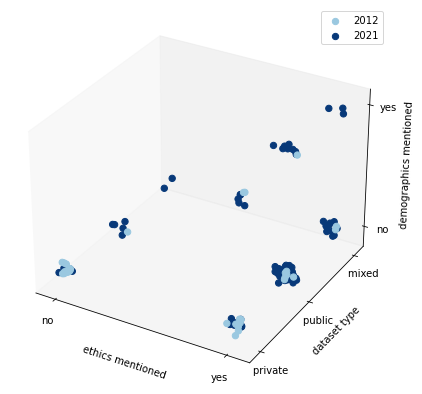

In [96]:
# Creating 3d scatterplot
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection='3d')

#plotting data
#ax.scatter3D(x,y,z, s = 32, alpha = 0.5)

ax.scatter3D(x12,y12,z12, s = 40, alpha = 1, c= '#9AC8E0')
ax.scatter3D(x21,y21,z21, s = 40, alpha = 1, c= '#083979')

#remove grid
ax.grid(False)

#set tick labels

plt.xticks([0, 1], ['no', 'yes'])
plt.yticks([0, 1, 2], ['private  ', 'public  ', 'mixed  '])

ax.set_zticks([0, 1])
ax.set_zticklabels(['no', 'yes'])

#set legend
plt.legend(['2012', '2021'])

#set axis labels 
ax.set_xlabel('ethics mentioned')
ax.set_ylabel('dataset type')
ax.set_zlabel('demographics mentioned')

#set title
#ax.set_title('4d scatterplot')

plt.savefig('square 1 with ethics, demographics, dataset type.png')

plt.show()
